https://youtu.be/nCMDZEScF-4

**Nuclei segmentation in whole slide H&E images**

using 20x trained StarDist model.

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

np.random.seed(0)
cmap = random_label_cmap()

In [71]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [72]:
def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

In [73]:
import json
from stardist.models import Config2D

model = load_model(r"\\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\monkey_ft_11_03_2023_lr_0.001_epochs_400_pt_40")

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.7141860056664086, nms=0.3) 



In [74]:
def show_tile(tile1, tile2, **kwargs):
    """Plot a pair of images."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(tile1, **kwargs)
    ax[1].imshow(tile2, **kwargs)

    for a in ax:
        a.set_axis_off()
        a.set_aspect('auto')  # Ensure aspect ratio is maintained

    plt.tight_layout()
    plt.show()

In [75]:
def show_tile(tile):
    fig, ax = plt.subplots(1,1,figsize = (8, 8))
    ax.imshow(tile)
    ax.axis('off')
    ax.set_title('H&E')

In [88]:
tile2_auth_path = r'\\10.99.68.178\Saurabh\Saurabh\Pancreas_Ashley_Files\20x_registered_cropped_region\Authentic_Slides\resized\TC_001_0002.tif'
tile2_synth_path = r'\\10.99.68.178\Saurabh\Saurabh\Pancreas_Ashley_Files\20x_registered_cropped_region\FILM_interpolation\resized\TC_001_0002.tif'

tile_valentia = r'\\motherserverdw\lab members\Ashley\LG HG PanIN project\donnie slide\tiles512'
tiles_val = os.listdir(tile_valentia)

tiles = [imread(tile2_auth_path), imread(tile2_synth_path)]
tiles = [imread(os.path.join(tile_valentia, t)) for t in tiles_val]

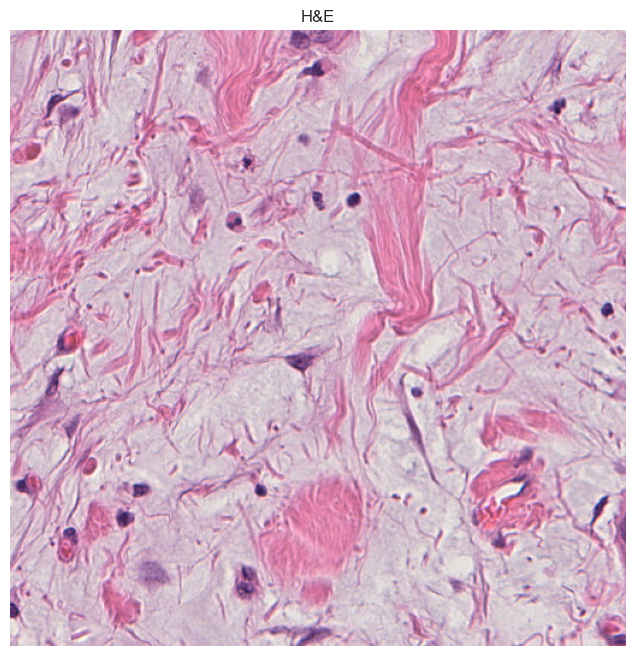

In [90]:
show_tile(tiles[1])

In [78]:
tiles[0].shape

(512, 512, 3)

In [94]:
from csbdeep.utils import Path, normalize
from stardist import fill_label_holes
from tqdm import tqdm  # progress bar class
from glob import glob

X = tiles

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

X = [x/255 for x in X]  # no norm, just divide by 255 to get into (0,1) range

Y_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X)]

100%|██████████| 2/2 [00:00<00:00, 11.43it/s]


In [80]:
def show_tile_segmented(tile, segmented, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(tile, **kwargs)

    # Plot the cropped image on the right
    ax[1].imshow(segmented, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

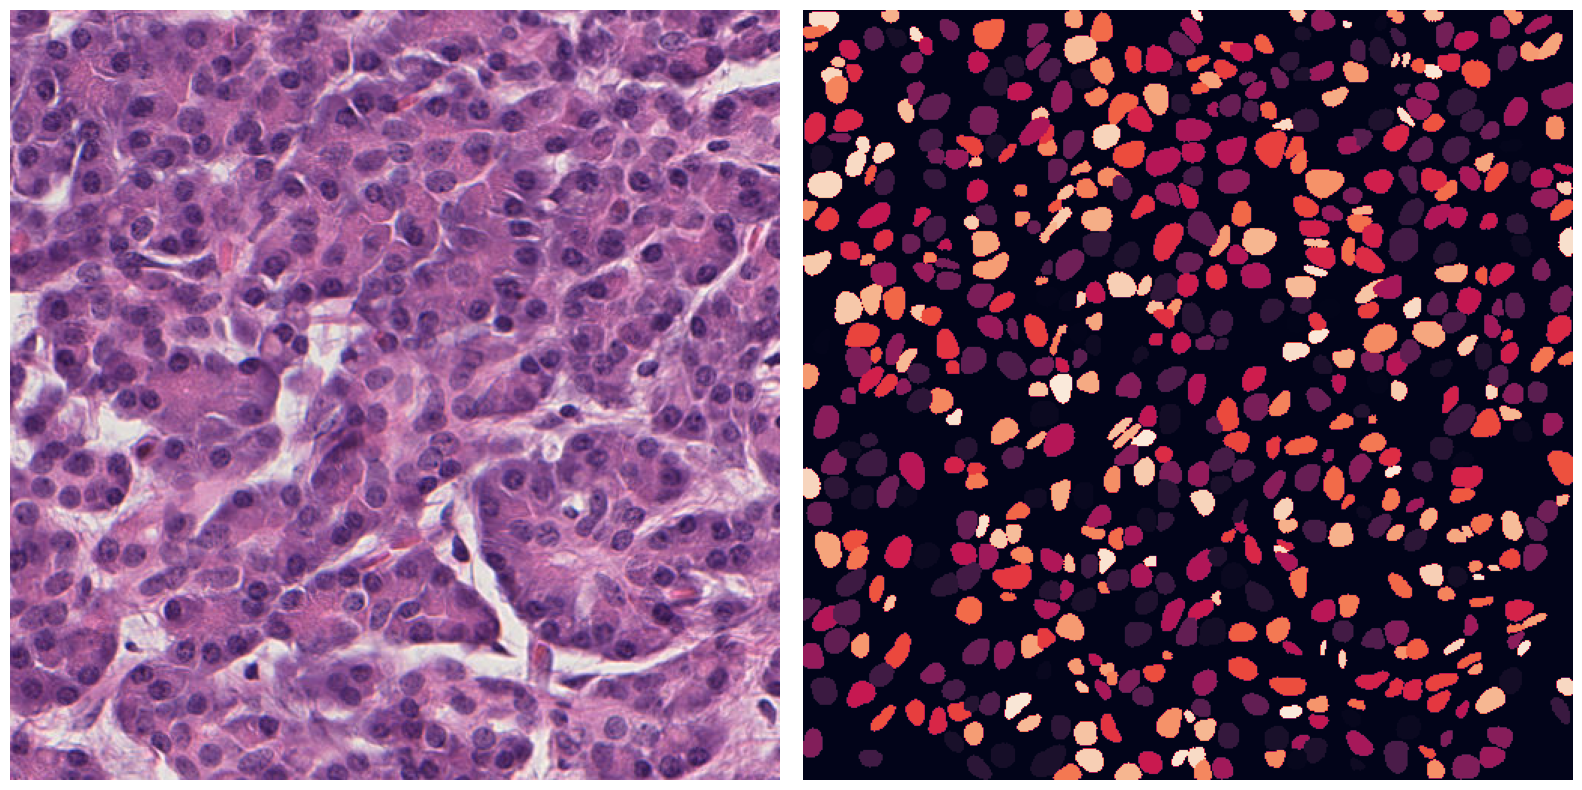

In [97]:
ind = 0

img = X[ind]
lbl = Y_pred[ind]

show_tile_segmented(img, lbl)

Text(0.5, 1.0, 'Predicted')

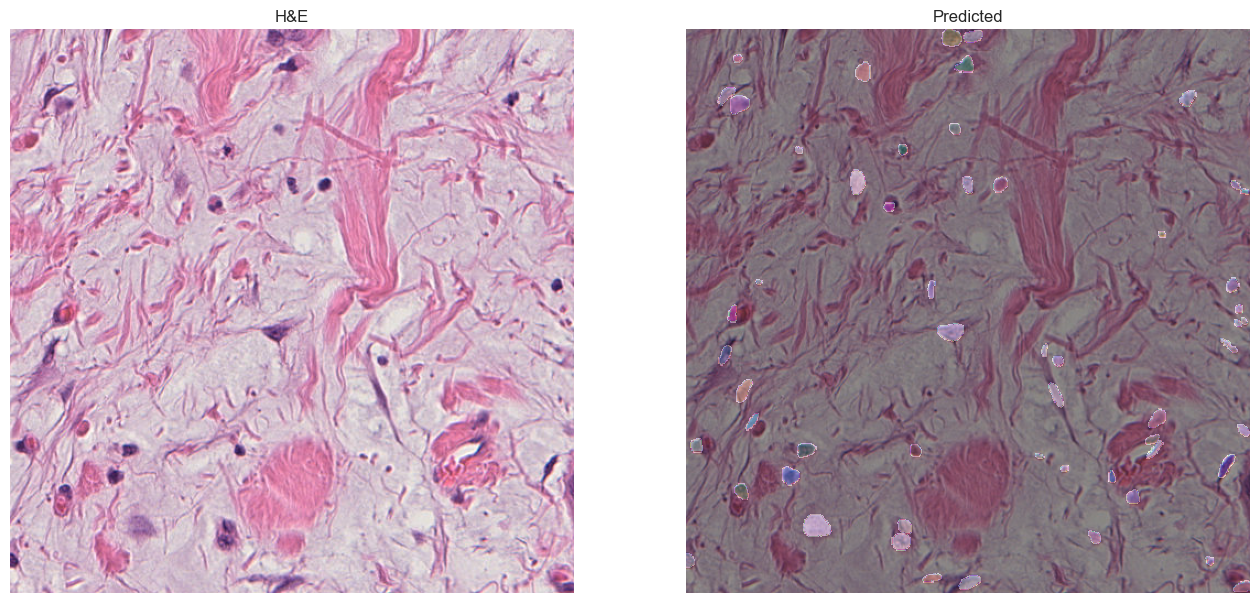

In [96]:
fig, ax = plt.subplots(1,2,figsize = (16, 8))
ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('H&E')

ax[1].imshow(img)
ax[1].imshow(lbl, cmap=lbl_cmap, alpha=0.4)
ax[1].axis('off')
ax[1].set_title('Predicted')

IndexError: list index out of range

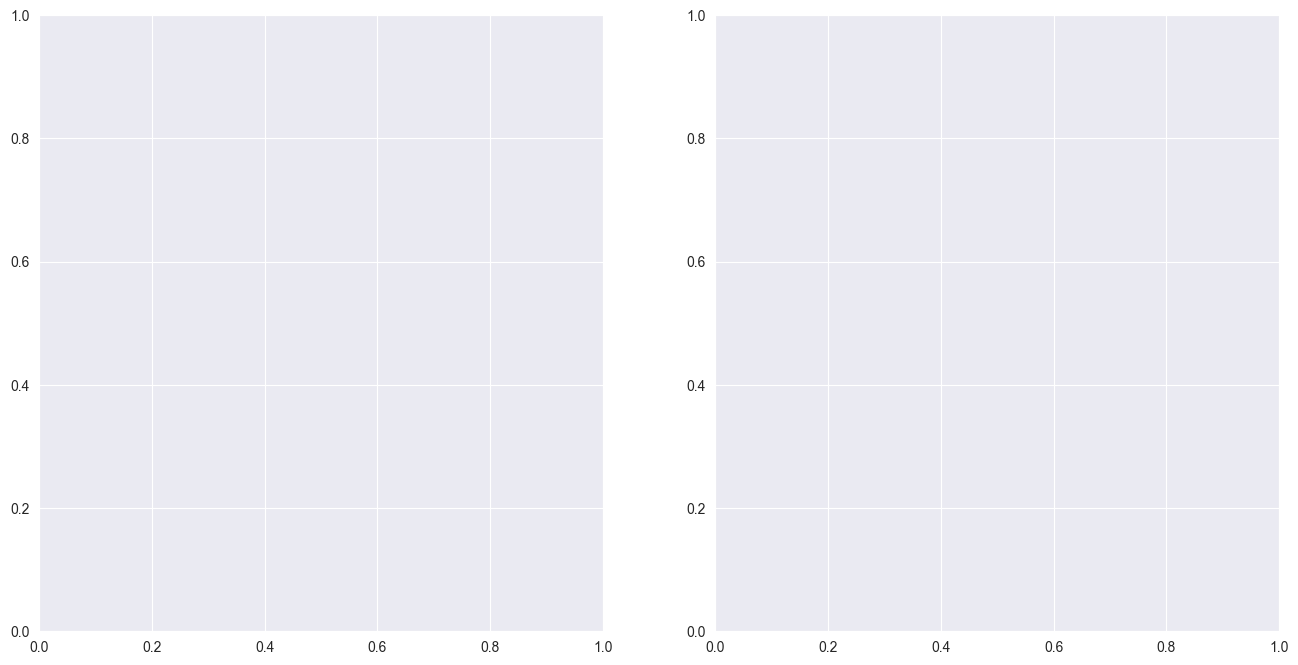

In [84]:
np.random.seed(42)
lbl_cmap = random_label_cmap()

fig, ax = plt.subplots(1,2,figsize = (16, 8))
ax[0].imshow(tiles[1])
ax[0].axis('off')
ax[0].set_title('H&E Authentic')

ax[1].imshow(tiles[0])
ax[1].imshow(Y_pred[0], cmap=lbl_cmap, alpha=0.4)
ax[1].axis('off')
ax[1].set_title('Authentic segmented')

fig, ax = plt.subplots(1,2,figsize = (16, 8))
ax[0].imshow(tiles[1])
ax[0].axis('off')
ax[0].set_title('H&E Synthetic')

ax[1].imshow(tiles[1])
ax[1].imshow(Y_pred[1], cmap=lbl_cmap, alpha=0.4)
ax[1].axis('off')
ax[1].set_title('Synthetic segmented')